In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# данные о домах
data = pd.read_csv('data/housing_data.csv').drop(15518)
# координаты домов
points = gpd.read_file('shapes/points/points.shp', encoding='utf-8').set_index('ID').to_crs(epsg=3035)
# сетка 1000 метров
grid1000 = gpd.read_file('shapes/grid1000/grid1000.shp', encoding='utf-8')
# сетка 1500 метров
grid1500 = gpd.read_file('shapes/grid1500/grid1500.shp', encoding='utf-8')
# карта районов города
districts = gpd.read_file('shapes/districts/districts.shp', encoding='utf-8')
districts=districts.to_crs(epsg=3035)

__Расположение__

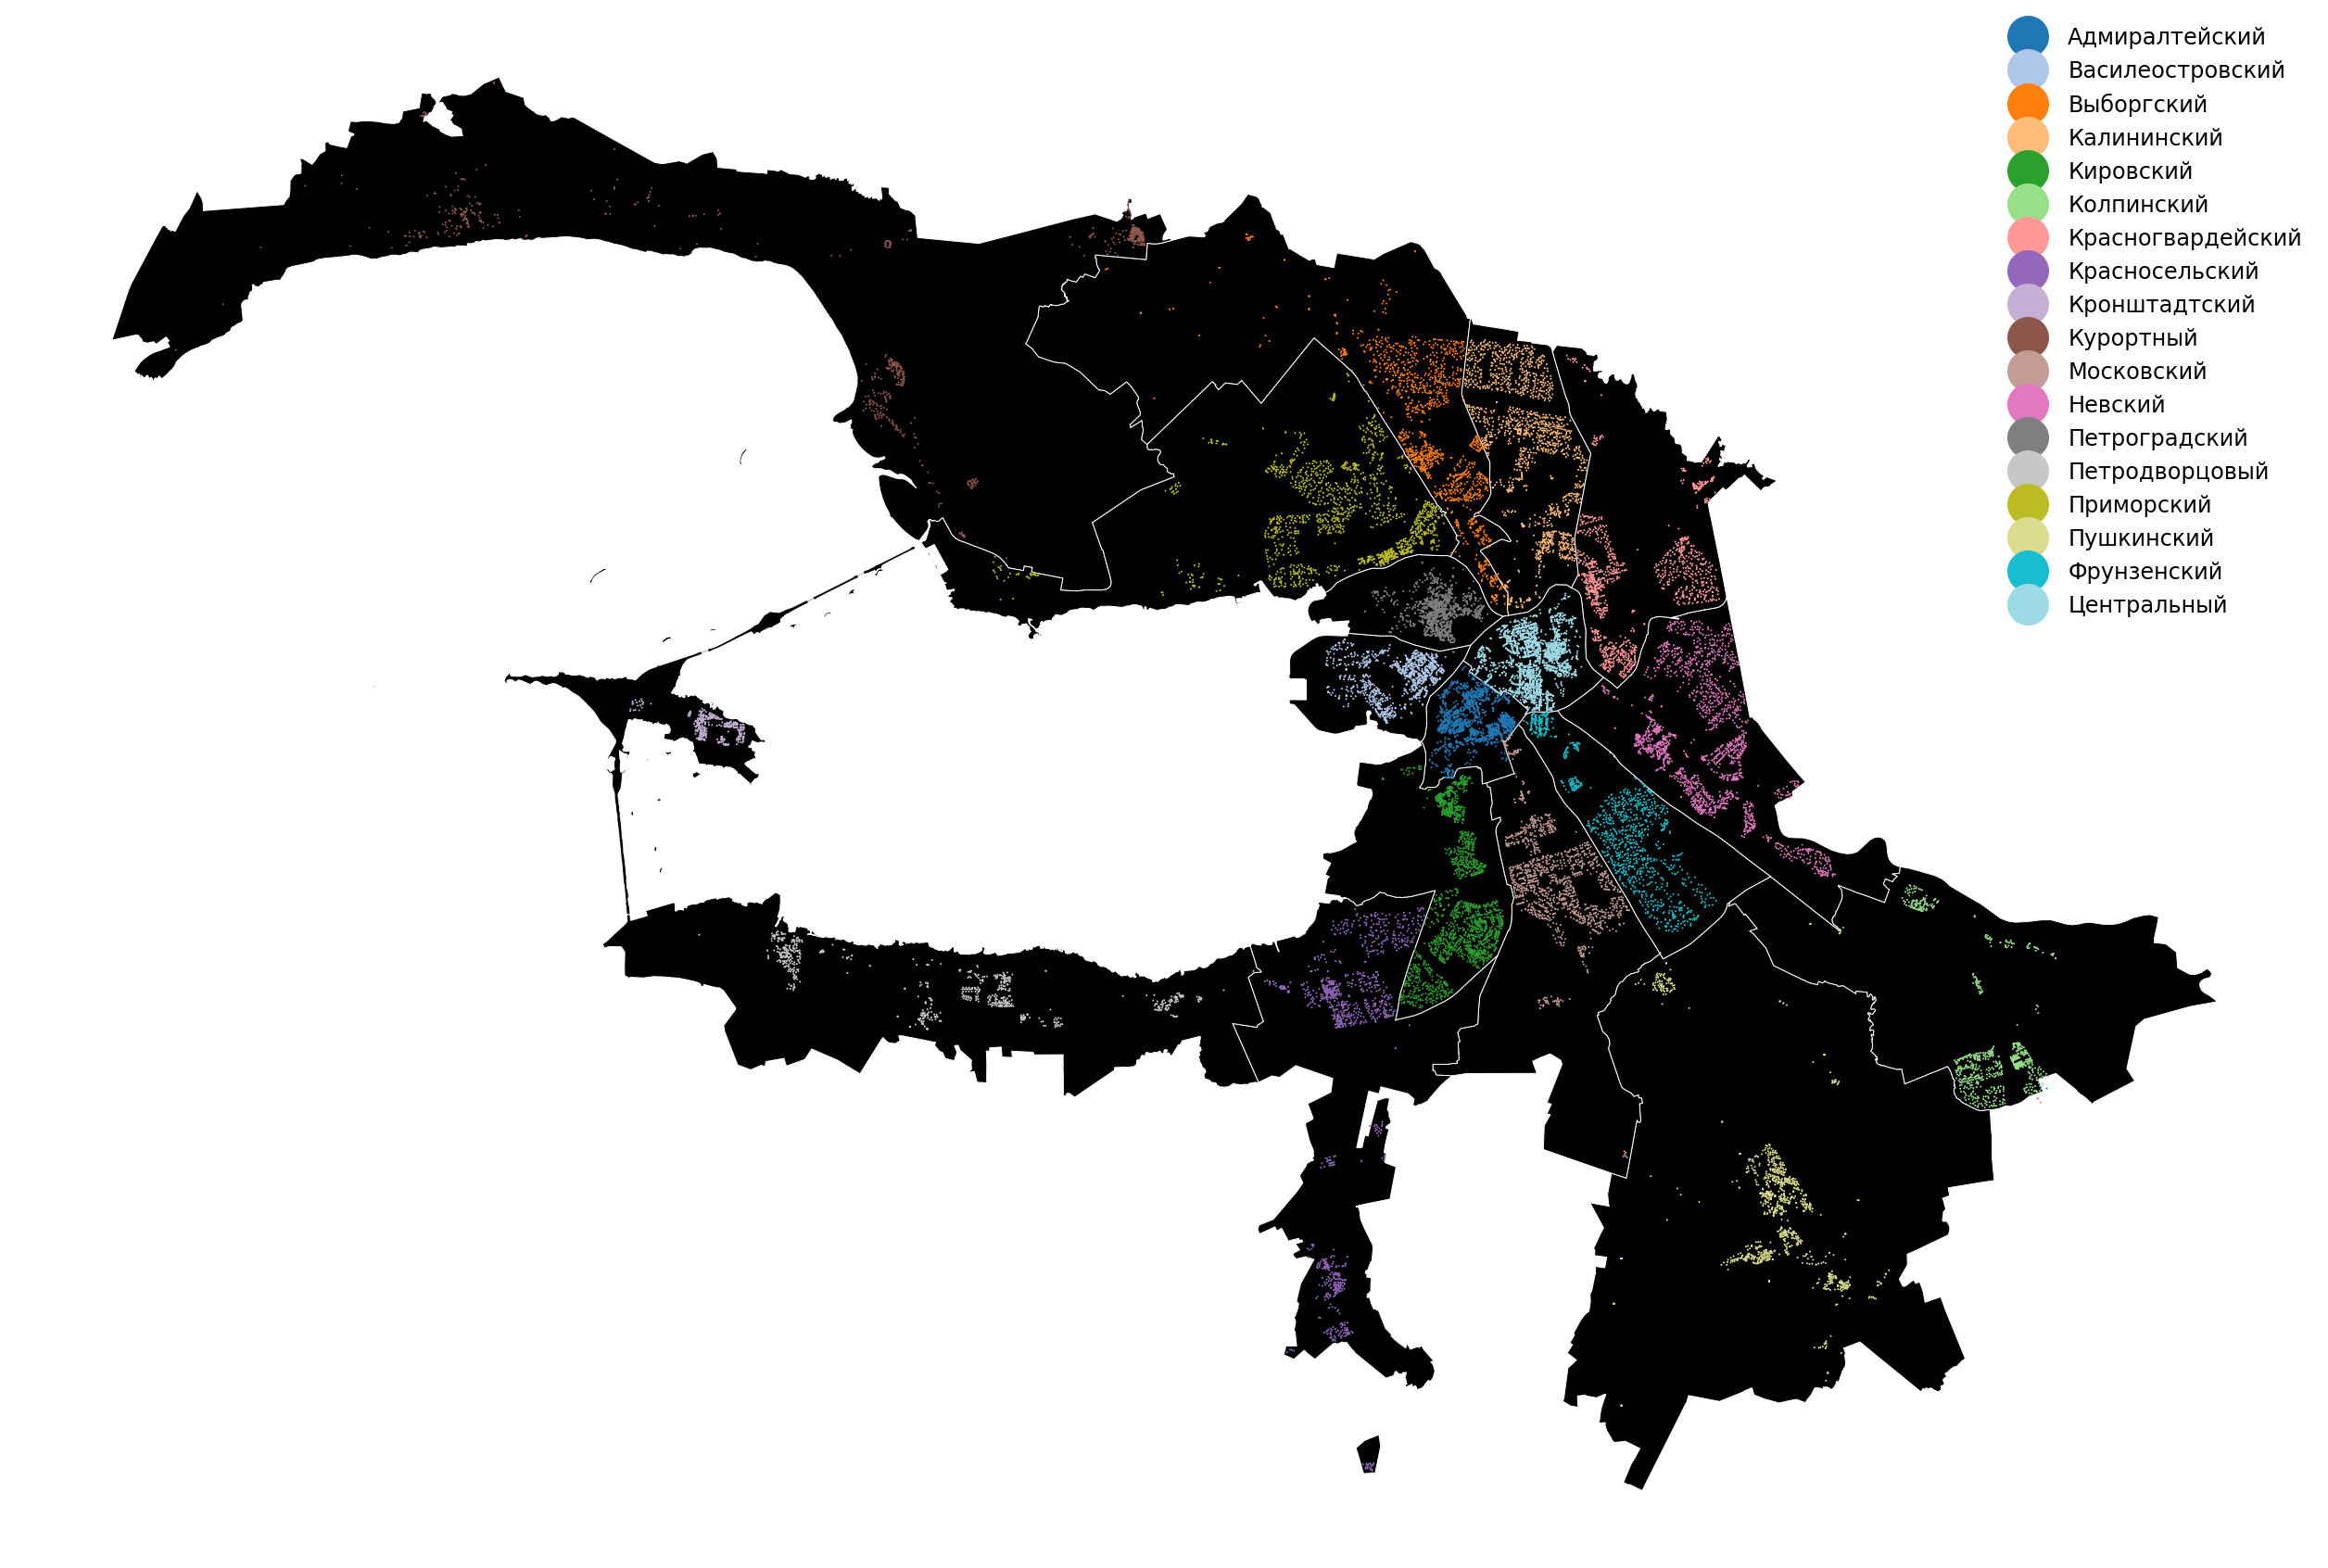

In [13]:
houses = gpd.GeoDataFrame(data[['addr_district', ]].join(points), geometry='geometry')

fig, ax = plt.subplots(figsize=(35, 25))#, dpi=200)
# ax.text(0.5, 1.0, 'Жилая застройка СПб', fontsize=46, horizontalalignment='center',transform=ax.transAxes)
ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.rc('legend', fontsize=24, markerscale=4.5, edgecolor='w')

districts.plot(ax=ax, color='k', edgecolor='w')
houses.plot(column='addr_district', cmap='tab20', ax=ax, legend=True, markersize=1)
plt.tight_layout()
plt.savefig('imgs/buildings.png', dpi=200)

__Период возведения__


In [30]:
def periodisation(year):
    year = int(year)
    if year <= 1917:
        return '1713-1917, До 1917'
    elif year < 1953:
        return '1918-1952, Ленин, Сталин' 
    elif year < 1964:
        return '1953-1963, Хрущев'
    elif year < 1982:
        return '1964-1981, Брежнев'
    elif year < 1991:
        return '1982-1990, Андропов, Черненко, Горбачев'
    else:
        return '1990-2019, Современная Россия'

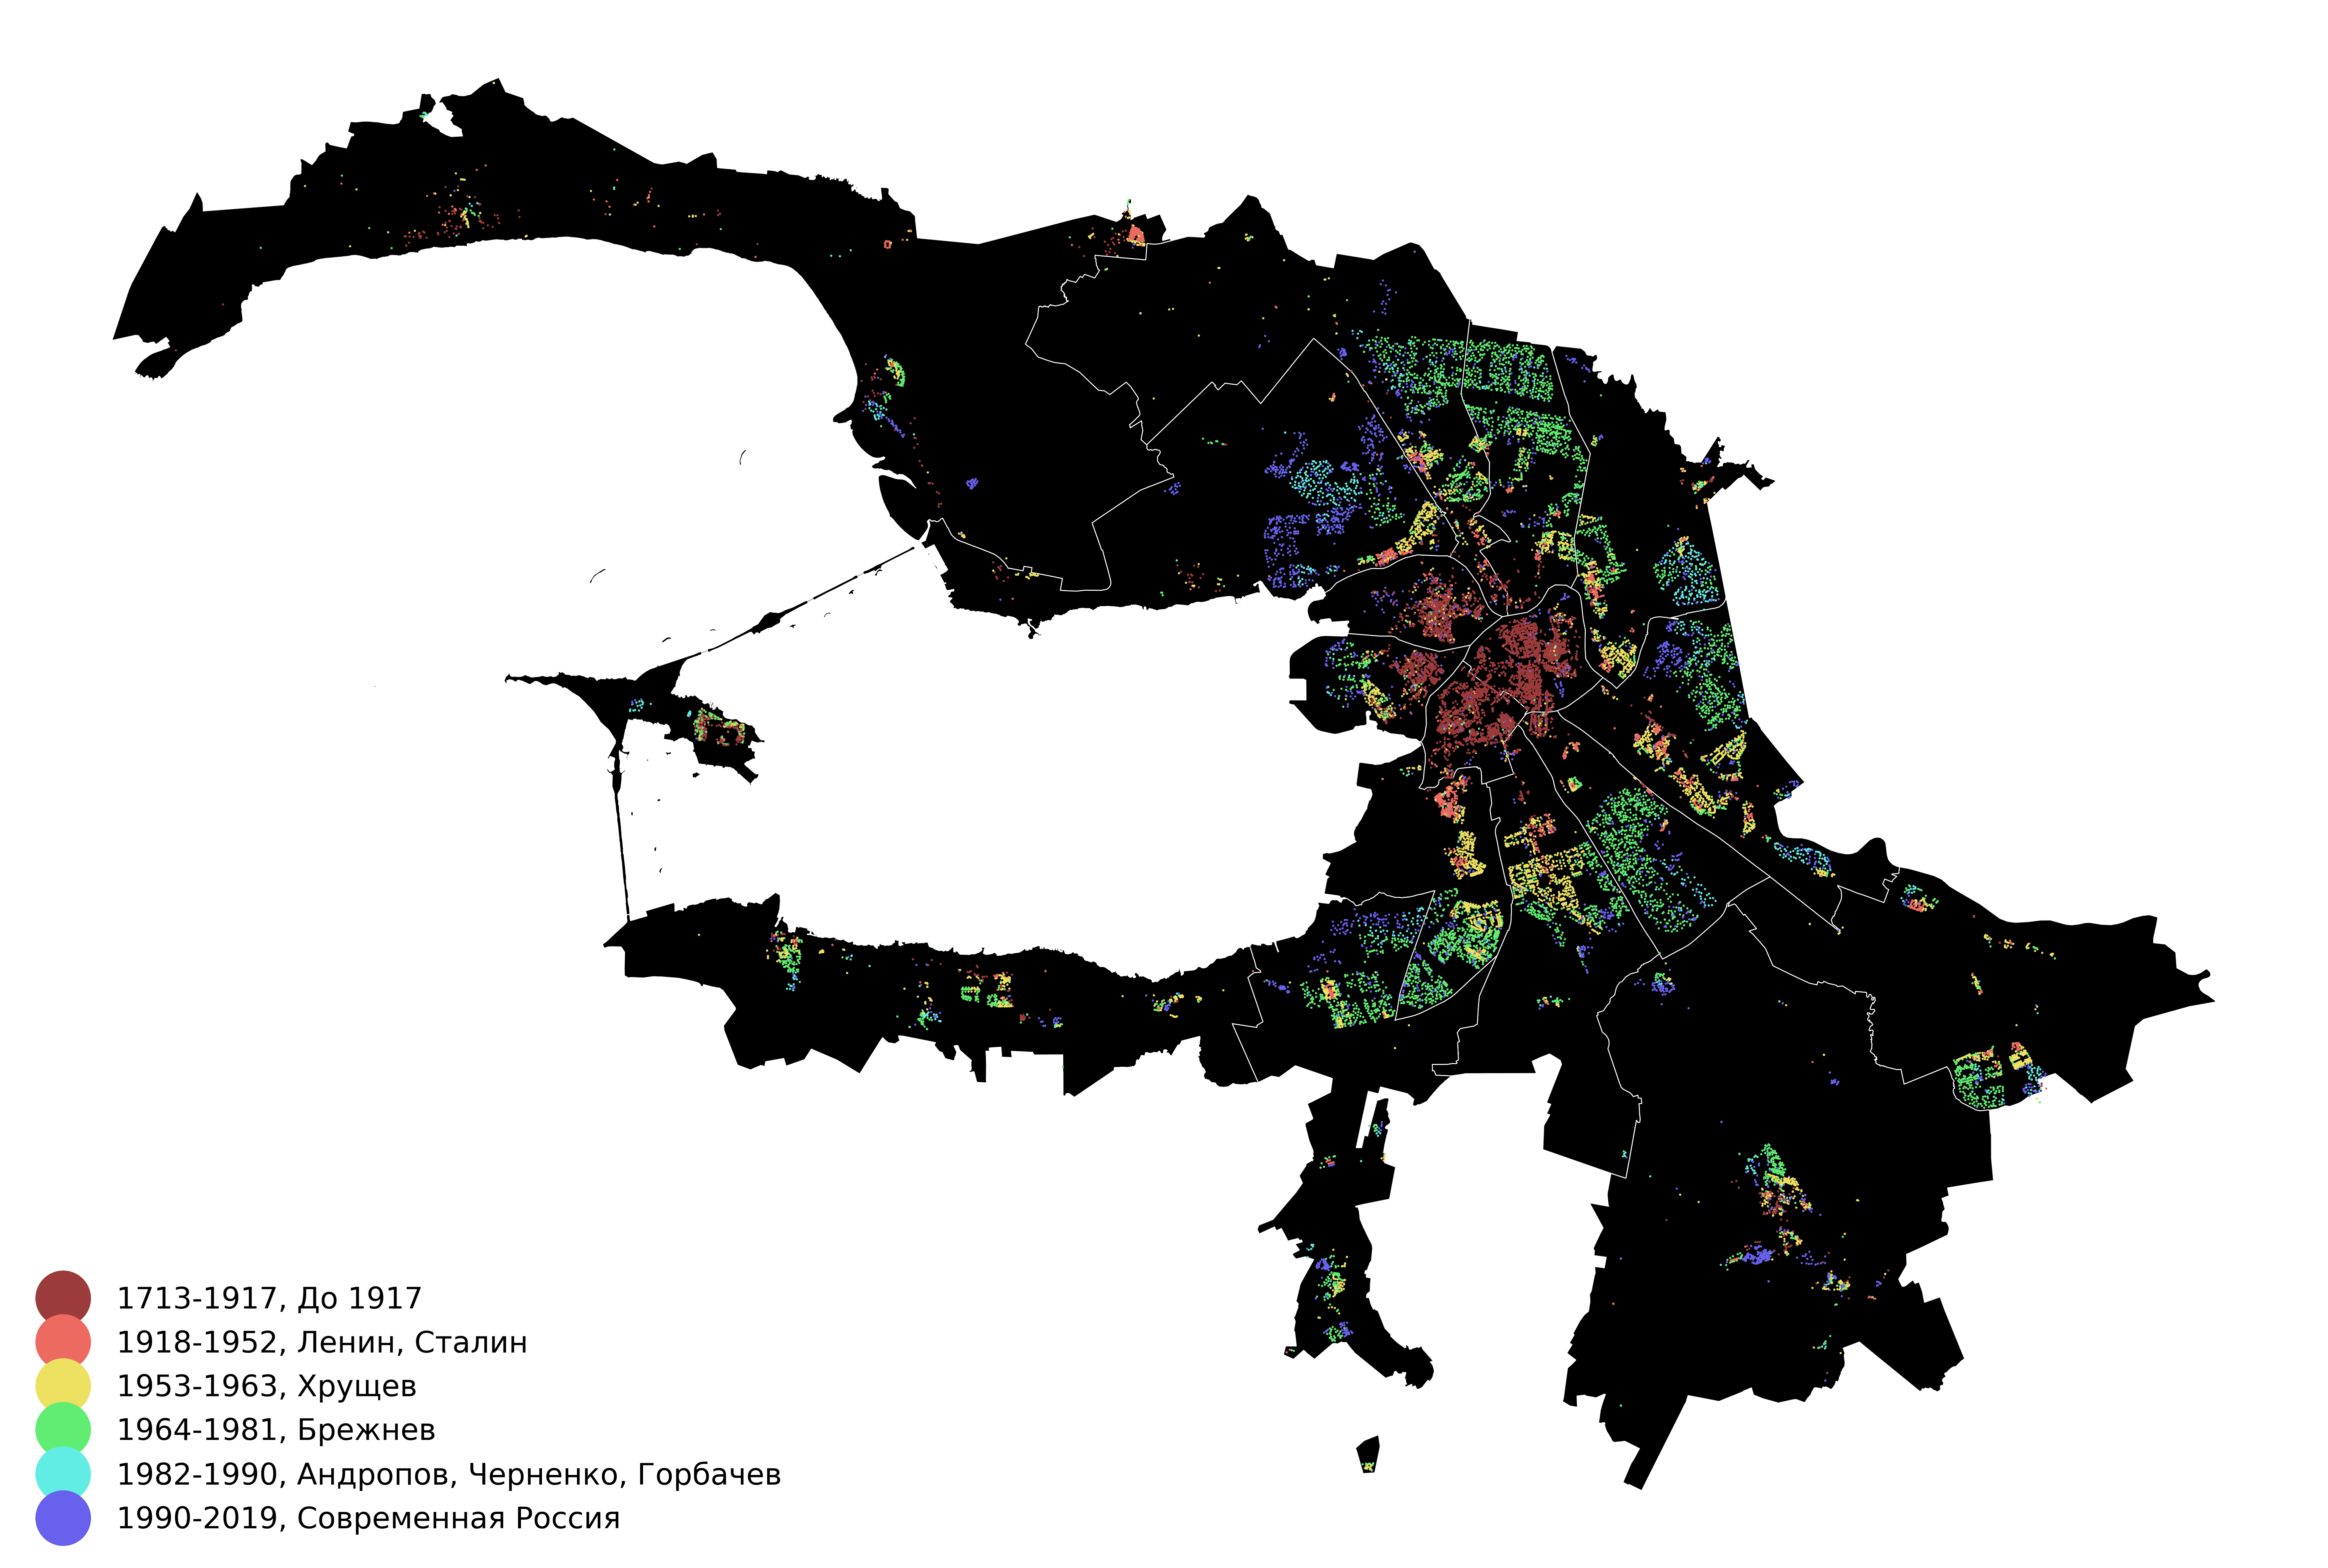

In [7]:
colors = ListedColormap(['#9c3b3b', '#ed6a61', '#ede161', '#61ed71', '#61ede4', '#6861ed'])

years = points.join(pd.DataFrame(pd.to_numeric(data['data_buildingdate'], errors='coerce')).dropna(), how='inner')
years = gpd.GeoDataFrame(years, geometry='geometry', crs={'init': 'epsg:3035'})
years['periodisation'] = years['data_buildingdate'].map(periodisation)

fig, ax = plt.subplots(figsize=(35, 25), dpi=200)
# ax.text(0.5, 1.0, 'Периоды застройки', fontsize=46, horizontalalignment='center', transform=ax.transAxes)
ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.rc('legend', fontsize=32, markerscale=6, edgecolor='w')

districts.plot(ax=ax, color='k', edgecolor='w')
years.plot(column='periodisation', cmap=colors, ax=ax, legend=True, markersize=2, legend_kwds={'loc': 'lower left'})
plt.tight_layout()
plt.savefig('imgs/building_periods.png', dpi=200)

Превалирующие годы застройки для квадратов 1000х1000 м.

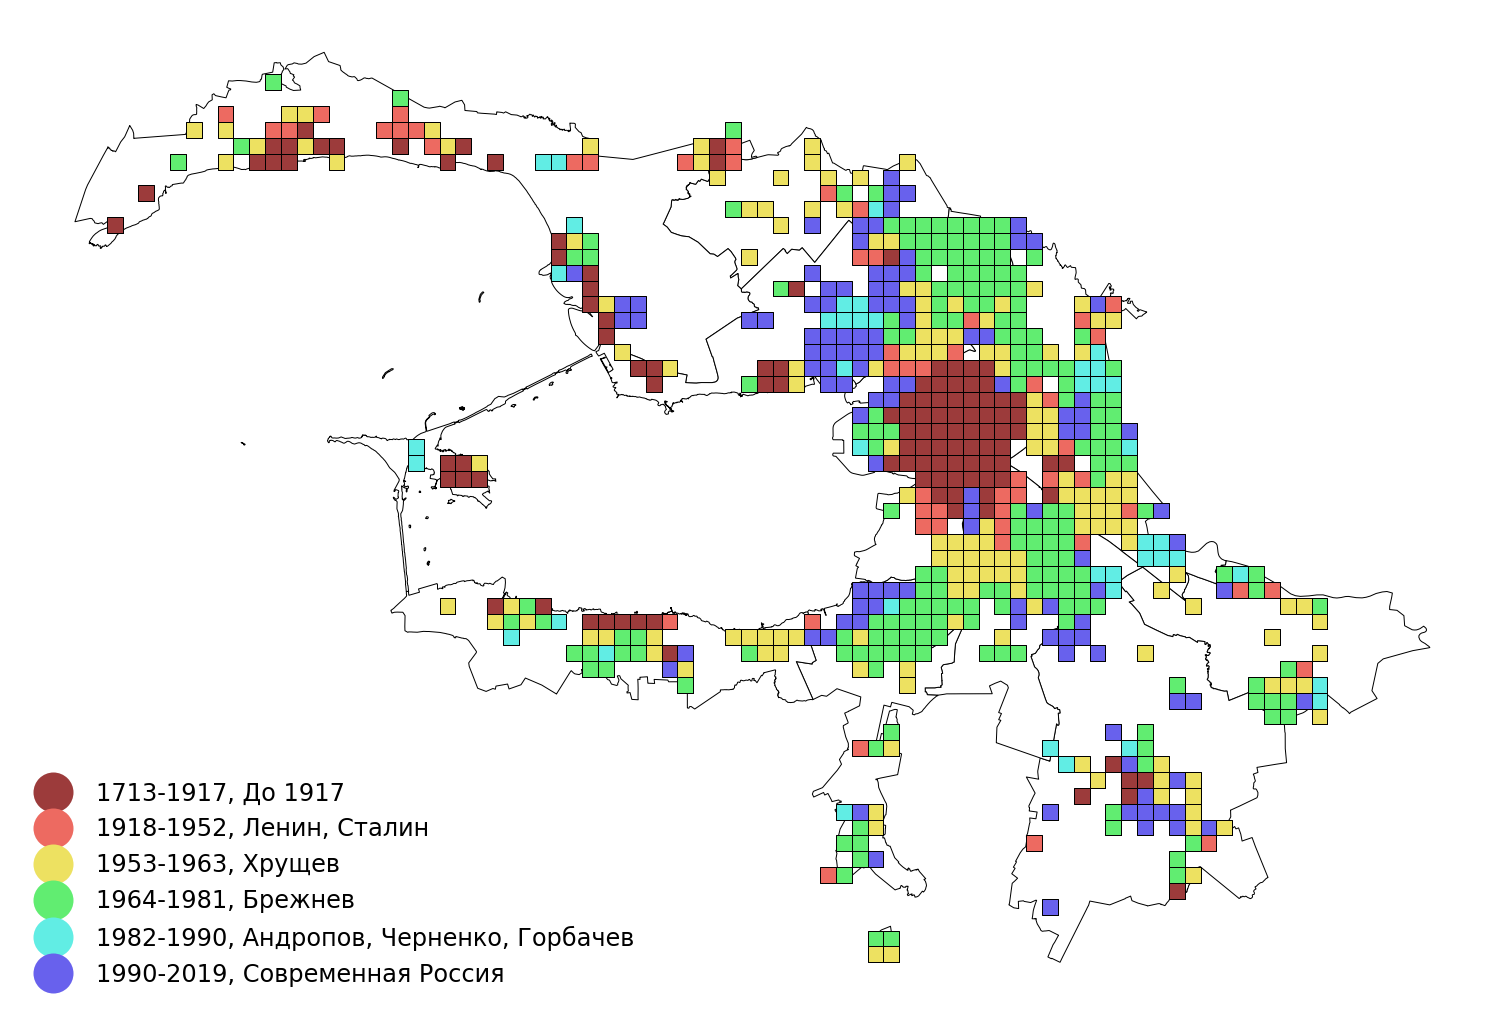

In [6]:
colors = ListedColormap(['#9c3b3b', '#ed6a61', '#ede161', '#61ed71', '#61ede4', '#6861ed'])

years_squares = gpd.sjoin(grid1000, years, op='contains')

years_squares = years_squares.groupby('FID')['periodisation'].agg(pd.Series.mode)
years_squares = years_squares.apply(lambda x: x[0] if type(x) == np.ndarray else x)
years_squares = gpd.GeoDataFrame(pd.DataFrame(years_squares).join(grid1000, on='FID'), geometry='geometry', crs={'init': 'epsg:3035'})

fig, ax = plt.subplots(figsize=(21, 15))
# ax.text(0.5, 1.0, 'Периоды застройки', fontsize=38, family='sans-serif', horizontalalignment='center', transform=ax.transAxes)
ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.rc('legend', fontsize=24, markerscale=4, edgecolor='w')

districts.plot(ax=ax, color='w', edgecolor='k')
years_squares.plot(column='periodisation', cmap=colors,  edgecolor='k', ax=ax, legend=True, legend_kwds={'loc': 'lower left'})
plt.tight_layout()
plt.savefig('imgs/building_periods_squares.png', dpi=100)

__Этажность__

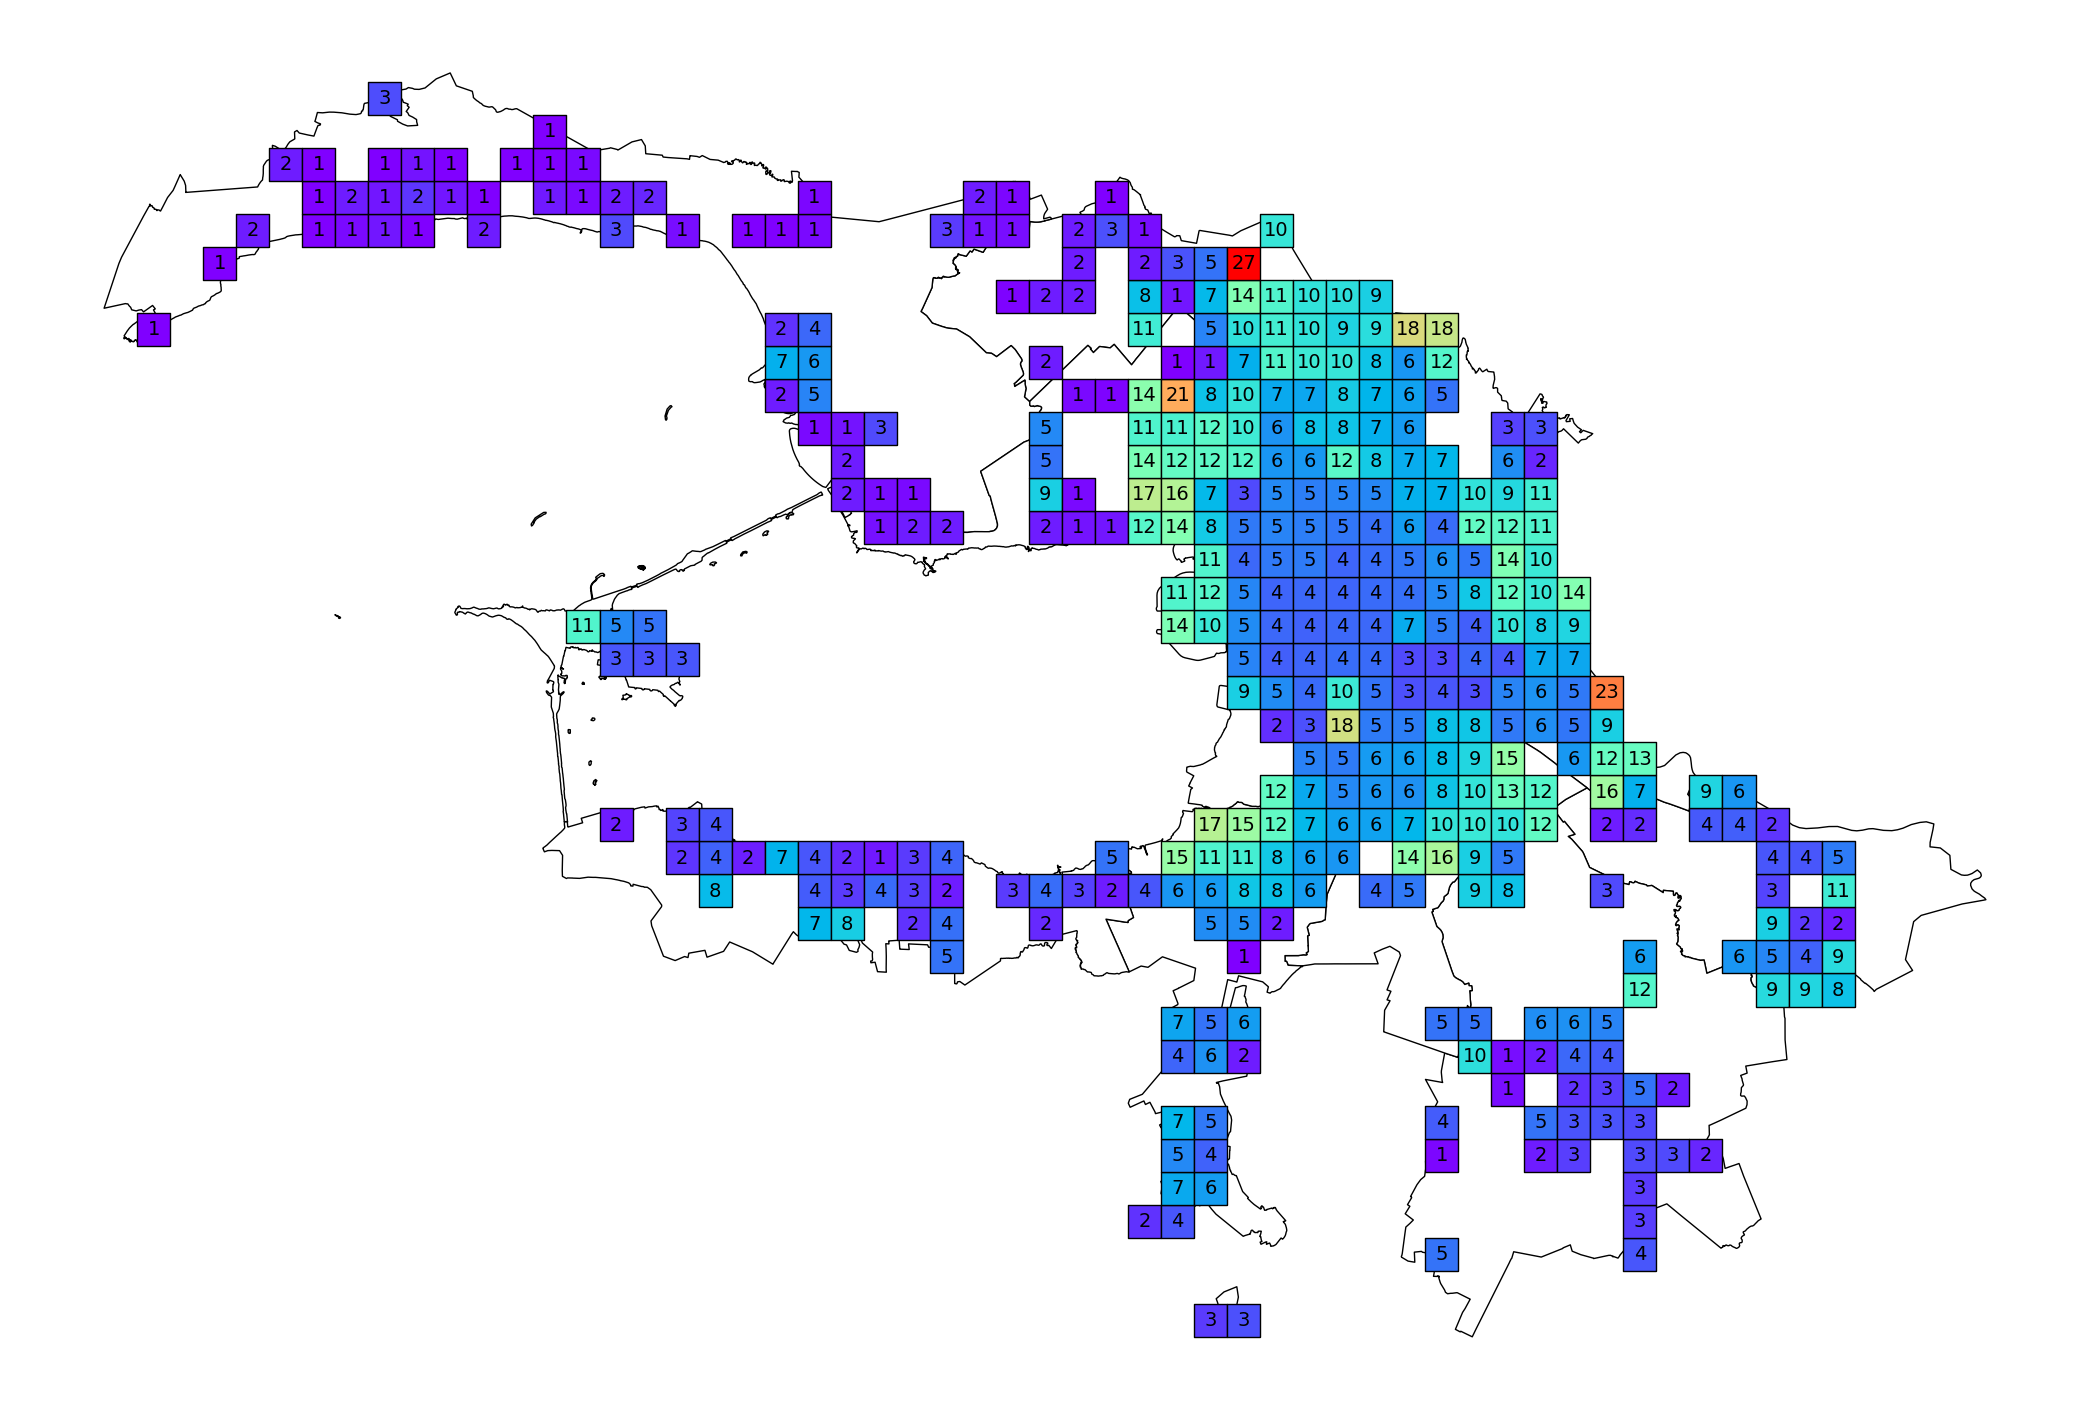

In [7]:
# отбираем интересующие данные из датасета
storeys = data[['data_storeys',]]
storeys = gpd.GeoDataFrame(storeys.join(points),
                           geometry='geometry',
                           crs={'init': 'epsg:3035'})
storeys = storeys.dropna()
storeys = gpd.sjoin(grid1500, storeys, op='contains')

storeys_sum = storeys.groupby('FID').sum()
storeys_count = storeys.groupby('FID').count()
storeys_sum['avg_storeys'] = storeys_sum['data_storeys'] / storeys_count['data_storeys']

storeys_sum = grid1500.join(storeys_sum)
storeys_sum = gpd.GeoDataFrame(storeys_sum, geometry='geometry', crs={'init': 'epsg:3035'})
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(21, 15), dpi=100)
# ax.text(0.5, 1.0, 'Этажность', fontsize=44, horizontalalignment='center', transform=ax.transAxes)

ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

storeys_sum['coords'] = storeys_sum['geometry'].apply(lambda x: x.representative_point().coords[:])
storeys_sum['coords'] = [list(coords[0]) for coords in storeys_sum['coords']]

districts.plot(ax=ax, color='w', edgecolor='k')

storeys_sum[(storeys_sum['avg_storeys'].notna())].plot(column='avg_storeys', ax=ax, cmap='rainbow', edgecolor='k')

for idx, row in storeys_sum[(storeys_sum['avg_storeys'].notna())].iterrows():
    try:
        ax.annotate(s=str(int(row['avg_storeys'])), xy=(row['coords'][0], row['coords'][1]), 
                    verticalalignment='center',
                     horizontalalignment='center', fontsize=14,
                     clip_on=True)
    except Exception:
        pass
ax.tick_params(top='off', bottom='off', left='off', right='off', labelbottom=False, labelleft=False)

plt.tight_layout()
plt.savefig('imgs/storeys_count_squares.png', dpi=100)  

plt.show()

__Плотность населения__

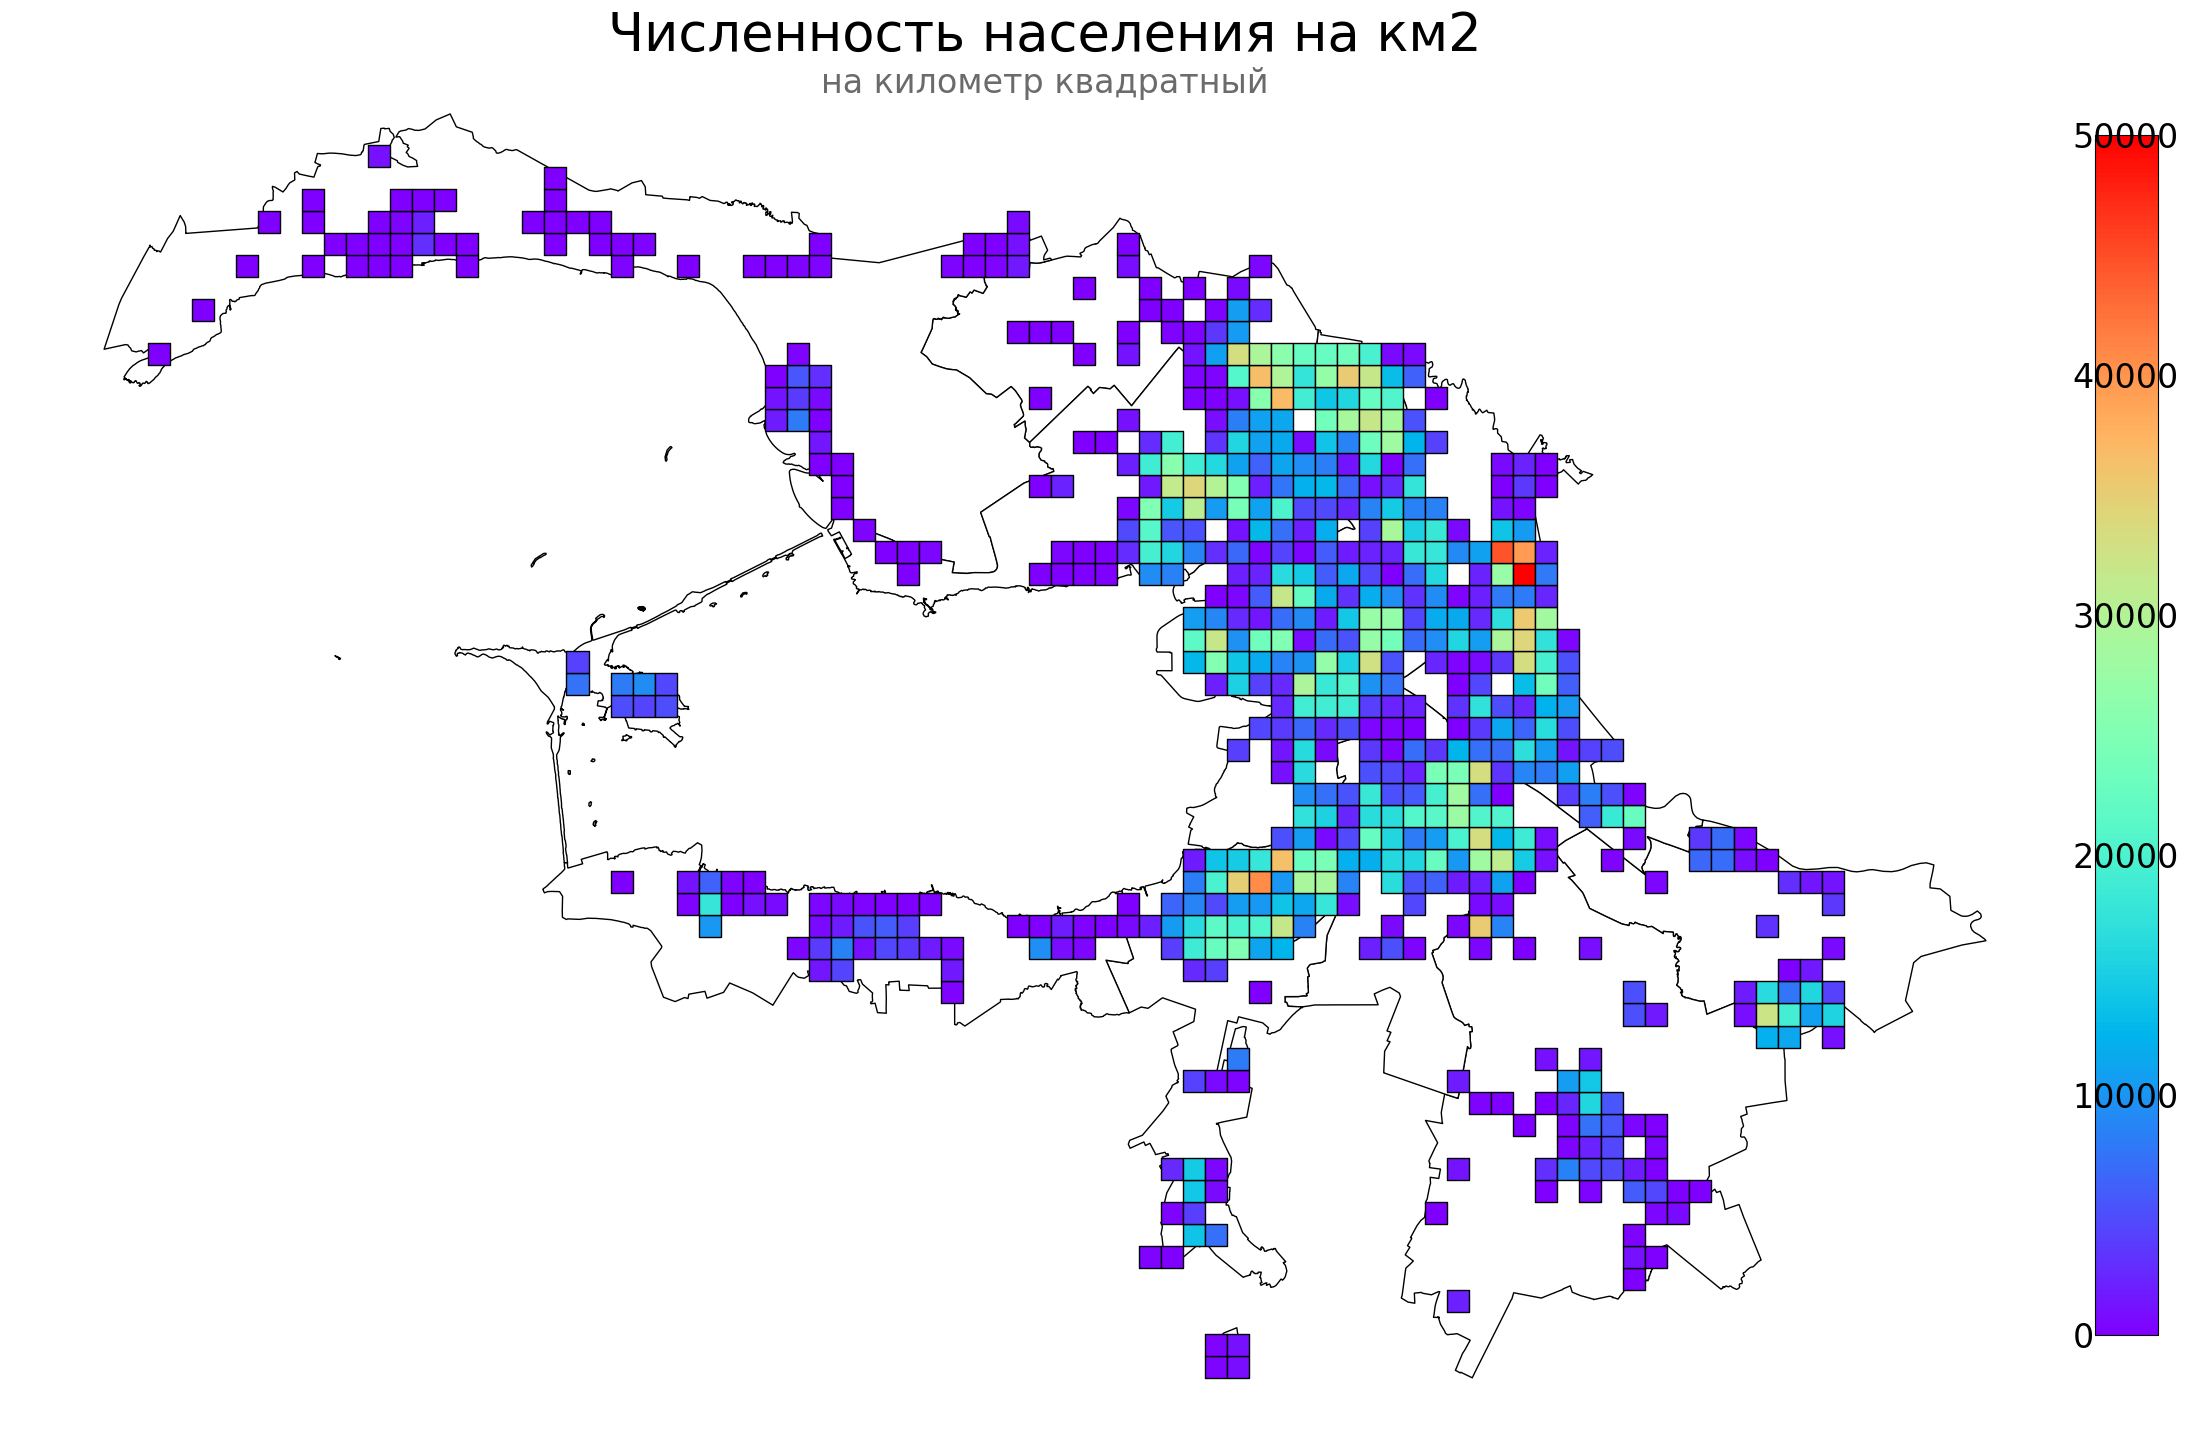

In [8]:
storeys = data[['data_residents',]]
storeys = gpd.GeoDataFrame(storeys.join(points), geometry='geometry', crs={'init': 'epsg:3035'})
storeys = storeys.dropna()
storeys = gpd.sjoin(grid1000, storeys, op='contains')

storeys_sum = storeys.groupby('FID').sum()#.drop(7095)

storeys_sum = grid1000.join(storeys_sum)
storeys_sum = gpd.GeoDataFrame(storeys_sum, geometry='geometry', crs={'init': 'epsg:3035'})

fig, ax = plt.subplots(1, 1, figsize=(21, 15), dpi=100)
ax.text(0.5, 1.0, 'Численность населения на км2', fontsize=38, horizontalalignment='center', transform=ax.transAxes)
ax.text(0.5, .97, 'на километр квадратный', fontsize=24, color='#6b6b6b', horizontalalignment='center', transform=ax.transAxes)
ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

districts.plot(ax=ax, color='w', edgecolor='k')

storeys_sum[(storeys_sum['data_residents'].notna())].plot(column='data_residents', ax=ax,  cmap='rainbow', edgecolor='k')# , cax=cax, legend=True)

cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0, vmax=50000))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=24, pad=-65, width=0) 

plt.tight_layout()

plt.savefig('imgs/population_squares.png', dpi=100) 
plt.show()

__Газификация__

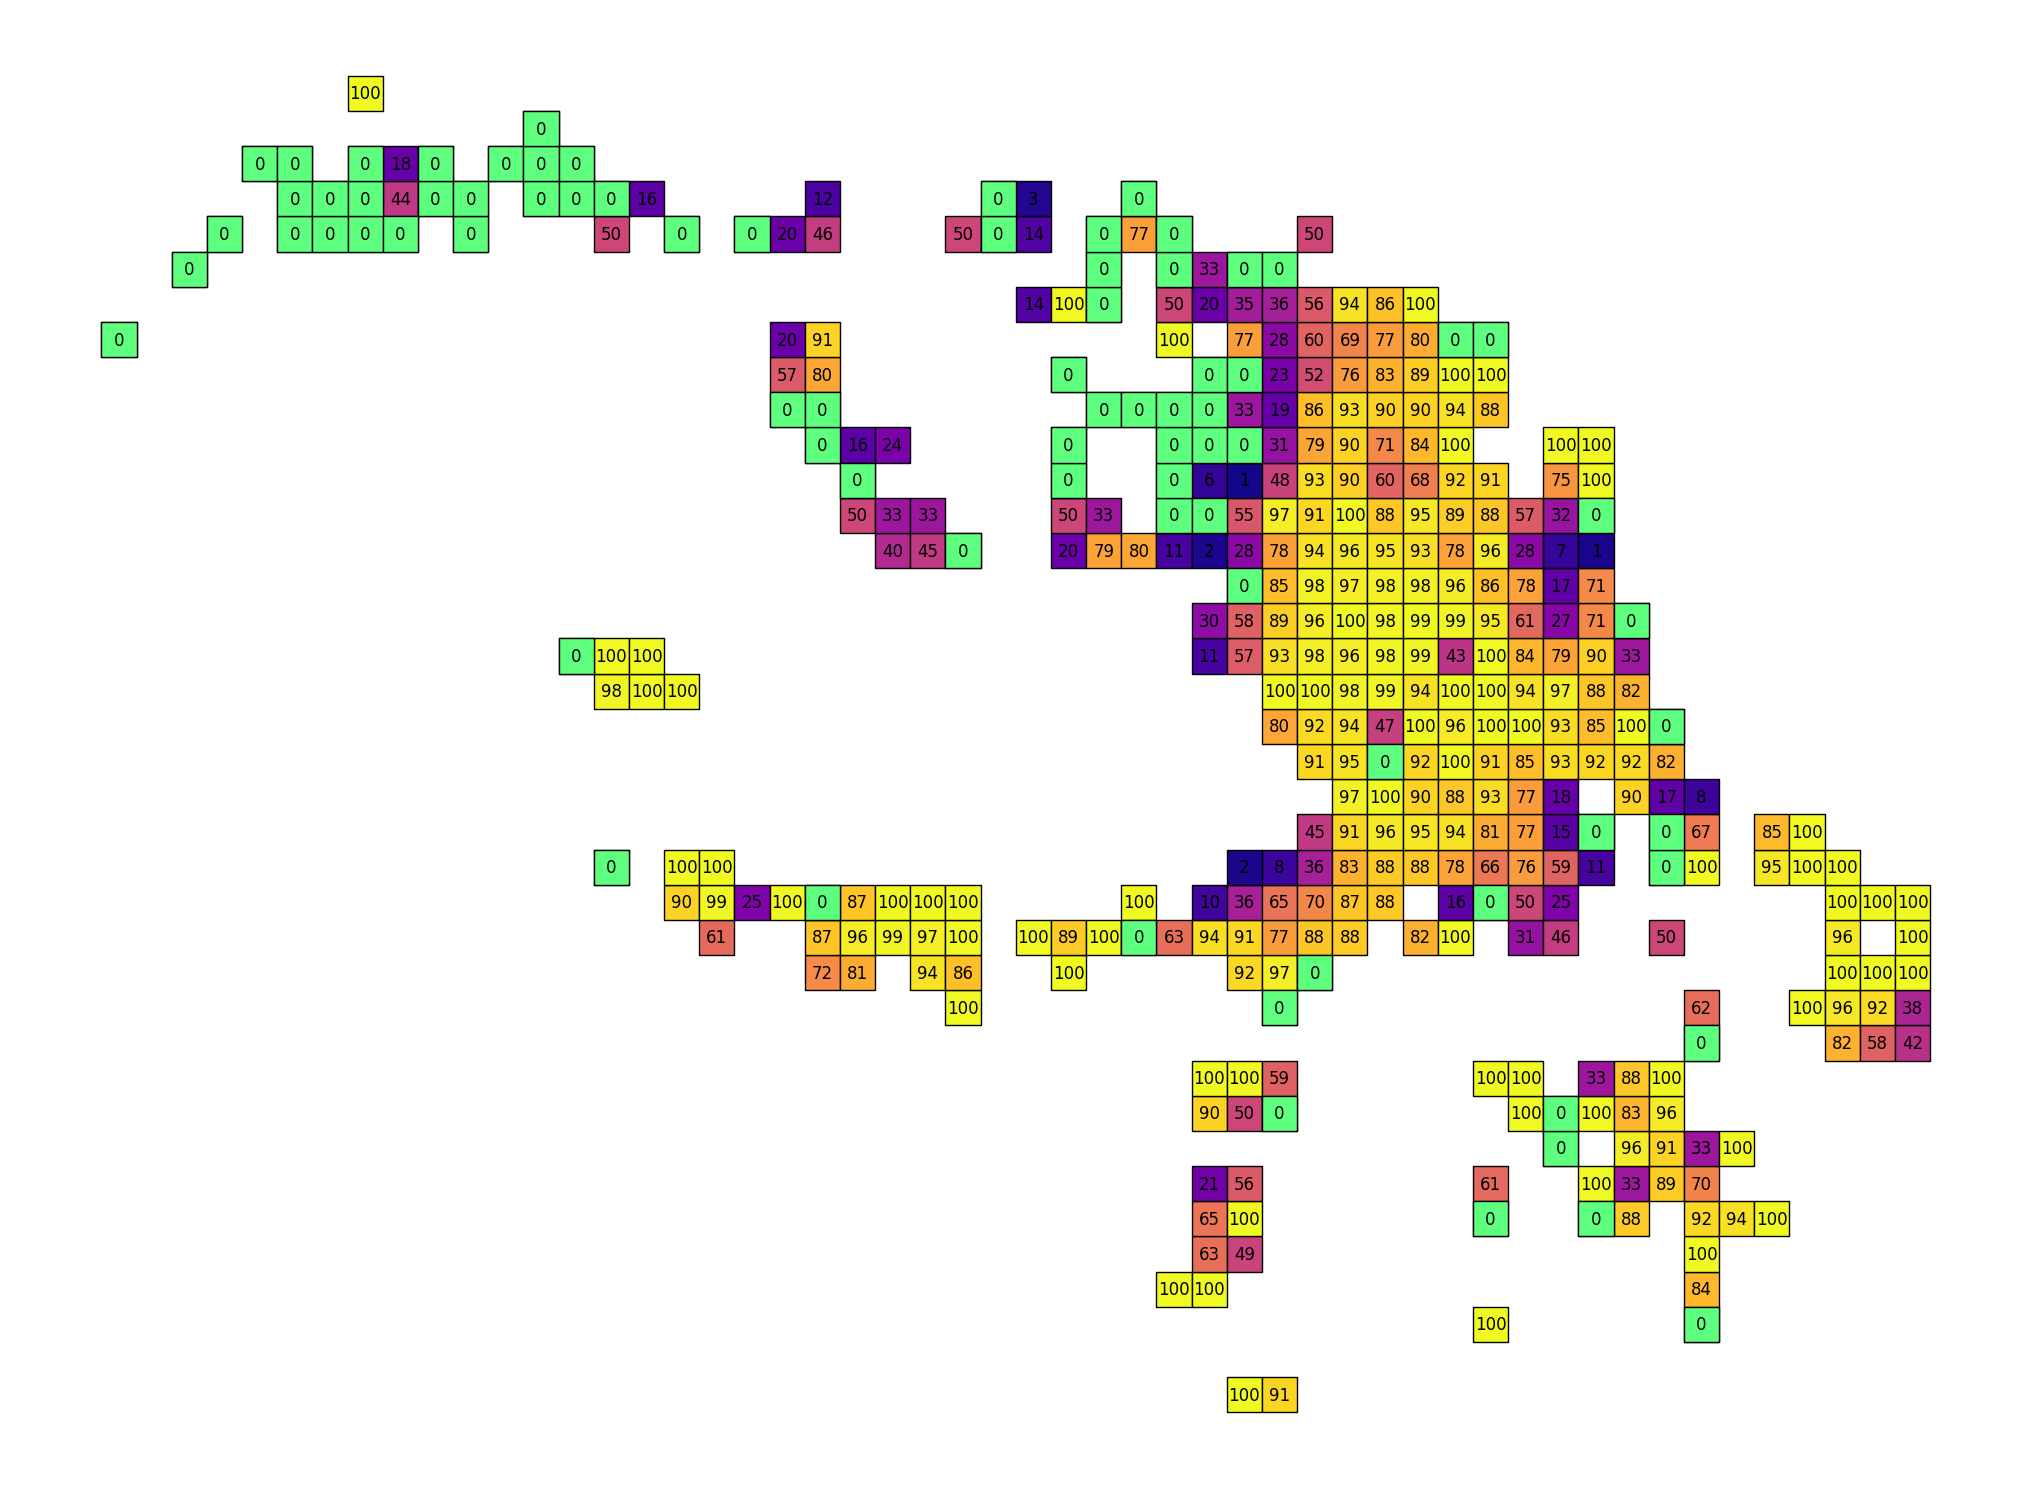

In [9]:
# отбираем интересующие данные из датасета
gas = data[['eng_gascentral', 'eng_gasnoncentral']]
gas = gpd.GeoDataFrame(gas.join(points), geometry='geometry', crs={'init': 'epsg:3035'})
gas = gpd.sjoin(grid1500, gas, op='contains')

gas = (gas.groupby('FID').sum() / gas.groupby('FID').count() * 100)[['eng_gascentral', 'eng_gasnoncentral']]

gas = grid1500.join(gas)
gas = gpd.GeoDataFrame(gas, geometry='geometry', crs={'init': 'epsg:3035'})

# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(figsize=(21, 15), dpi=100)
ax.set(frame_on = False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# ax.text(0.5, 1.0, 'Газификация', fontsize=38, family='sans-serif', horizontalalignment='center', transform=ax.transAxes)

gas['coords'] = gas['geometry'].apply(lambda x: x.representative_point().coords[:])
gas['coords'] = [list(coords[0]) for coords in gas['coords']]

gas[(gas['eng_gascentral'].notna())].plot(column='eng_gascentral', ax=ax, 
                                                cmap='plasma',
                                               edgecolor='k', legend=False)
gas[(gas['eng_gascentral'].notna()) & (gas['eng_gascentral'] == 0)].plot(column='eng_gascentral', ax=ax, 
                                                 color='#5eff7e',
                                               edgecolor='k', legend=False)

for idx, row in gas[(gas['eng_gascentral'].notna())].iterrows():
    try:
        ax.annotate(s=str(int(row['eng_gascentral'])), xy=(row['coords'][0], row['coords'][1]), 
                    verticalalignment='center',
                     horizontalalignment='center', fontsize=12,
                     clip_on=True)
    except Exception:
        pass
    
plt.tight_layout()
plt.savefig('imgs/gas_squares.png', dpi=100)    
    
plt.show()